In [ ]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import re
print(sys.executable)
from tqdm import tqdm
import json
from currency_converter import CurrencyConverter
from scipy.stats import ttest_ind


c:\Users\shubh\Documents\vgchartz\.venv\Scripts\python.exe


In [9]:
# Merge the simple CSVs based on app_id
gamesdf = pd.read_csv("./games.csv", quotechar='"', escapechar='\\', dtype="str")
genresdf = pd.read_csv("./genres.csv", quotechar='"', escapechar='\\', dtype="str")
gamesdf = pd.merge(gamesdf, genresdf, on="app_id")
reviewsdf = pd.read_csv("./reviews.csv", quotechar='"', escapechar='\\', dtype="str")
gamesdf = pd.merge(gamesdf, reviewsdf, on="app_id")

In [10]:
### NA values are written as 'N'. Let us fix this below

gamesdf = gamesdf.map(lambda x: np.nan if x == "N" else x)


### The languages column has <strong> tags around * symbols in it sometimes. Let's get rid of these.

gamesdf["languages"] = gamesdf["languages"].str.replace("<strong>*</strong>", "")


### Those asterixes correspond to having full audio support for those languages.
# We don't really care about this so let's get rid of that too
gamesdf["languages"] = gamesdf["languages"].str.replace("<br>languages with full audio support", "")


### Used to check if values are converted correctly. No rows should display if all values with 'N' are properly converted to NaN
# matches = gamesdf == 'N'
# display(gamesdf[matches.any(axis=1)])





In [11]:
### Some columns aren't typed properly. For example is_free is typed as an object instead of a boolean.

# Let's convert the release date to datetimes
gamesdf["release_date"] = pd.to_datetime(gamesdf["release_date"])

# Now let's convert the is_free column. It uses 0's and 1's to represent false or true respectively
# Let's map that to a boolean
gamesdf["is_free"] = gamesdf["is_free"].apply(lambda x : False if x == '0' else True)


# Let's convert the languages into a list of of strings
gamesdf["languages"] = gamesdf["languages"].str.split(",")




### Let's convert the following columns to integers
toIntegerColumnNames = []

# Let's convert the review scores as well as the positive, negative, and total review counts to integers
toIntegerColumnNames.append("review_score") 
toIntegerColumnNames.append("positive")
toIntegerColumnNames.append("negative")
toIntegerColumnNames.append("total")

# Let's convert the metacritic scores to integers too
toIntegerColumnNames.append("metacritic_score")

# Let's convert the recommendation counts to integers
toIntegerColumnNames.append("recommendations")


# Let's convert the steamspy user scores, score ranks, positive review counts, and negative review counts to integers
toIntegerColumnNames.append("steamspy_user_score")
toIntegerColumnNames.append("steamspy_score_rank")
toIntegerColumnNames.append("steamspy_positive")
toIntegerColumnNames.append("steamspy_negative")


# Okay let's convert all of these to integers now! :)
for columnName in toIntegerColumnNames:
    gamesdf[columnName] = gamesdf[columnName].apply(lambda x: int(x) if pd.notna(x) else x)


# display(gamesdf.head()) #checking work
# print(gamesdf.dtypes) #checking work

In [12]:
### Unpacking the price_overview column

#Note that I divide these prices by 100 since they don't have appropriate decimals (i.e. 819 = $8.19)
gamesdf["final_price"] = gamesdf["price_overview"].apply(lambda x : (json.loads(x))["final"]/100 if pd.notna(x) else x)
gamesdf["initial_price"] = gamesdf["price_overview"].apply(lambda x : (json.loads(x))["initial"]/100 if pd.notna(x) else x)
gamesdf["currency"] = gamesdf["price_overview"].apply(lambda x : (json.loads(x))["currency"] if pd.notna(x) else x)
gamesdf["discount_percent"] = gamesdf["price_overview"].apply(lambda x : (json.loads(x))["discount_percent"] if pd.notna(x) else x)


print(gamesdf["currency"].unique())
print(gamesdf["discount_percent"].unique())

['EUR' 'MXN' nan 'RUB' 'USD' 'CAD' 'BRL' 'SAR' 'GBP' 'PEN' 'ILS' 'KRW'
 'UAH' 'INR' 'PHP' 'IDR' 'PLN' 'COP' 'AUD' 'NZD' 'SGD' 'THB' 'CNY' 'KWD'
 'KZT' 'MYR' 'TWD' 'JPY' 'AED' 'HKD' 'VND' 'NOK']
[ 0. nan 80. 67. 85. 90. 70. 86. 89. 65. 75. 60. 50. 76. 78. 55. 72. 66.
 30. 87. 95. 83. 92. 68. 51. 84. 91. 88. 35. 20. 82. 25. 61. 40. 24. 49.
 59. 57. 52. 64. 81. 77. 10. 79. 33. 45. 15. 73. 56. 53. 94. 37. 39. 31.
 34. 63. 44. 46. 93. 26. 42. 69. 54. 22. 47. 43. 71. 27. 38. 48. 62. 17.
 21. 19. 29. 18. 32. 58. 11. 36. 41. 12. 28.]


In [13]:
### Converting all prices to USD
unique_currencies = gamesdf["currency"].dropna().unique()

conversion_rates = {}

converter = CurrencyConverter(fallback_on_missing_rate=True)
for currency in unique_currencies:
        if currency != 'USD':
            try:
                conversion_rates[currency] = converter.convert(1, currency, 'USD')
            except: #in case anything ever goes wrong with the library
                conversion_rates[currency] = None


#### WARNING: THESE NEXT FEW CURRENCIES ARE MANUALLY BEING UPDATED

## Inputing conversion rates for currencies that don't have one (taken from wise.com)
conversion_rates["SAR"] = 0.2666
conversion_rates["PEN"] = 0.2726
conversion_rates["UAH"] = 0.02433
conversion_rates["COP"] = 0.0002413
conversion_rates["KWD"] = 3.243
conversion_rates["KZT"] = 0.001986
conversion_rates["TWD"] = 0.03011
conversion_rates["AED"] = 0.2723
conversion_rates["VND"] = 0.00003902

for currency, rate in conversion_rates.items():
        currency_rows = (gamesdf['currency'] == currency) #find all rows with this currency
        gamesdf.loc[currency_rows, "currency"] = "USD" #set the currencies to usd now
        gamesdf.loc[currency_rows, "initial_price"] = (gamesdf.loc[currency_rows, "initial_price"] * rate) #convert the initial prices
        gamesdf.loc[currency_rows, "final_price"] = (gamesdf.loc[currency_rows, "final_price"] * rate) #convert the final prices


### Rounding the prices to two decimals
gamesdf["initial_price"] = gamesdf["initial_price"].round(2) #rounding the initial prices
gamesdf["final_price"] = gamesdf["final_price"].round(2) #rounding the final prices

# Fixing free games
gamesdf.loc[gamesdf["is_free"] == True, ["initial_price", "final_price"]] = 0





### TODO: Use some sort of imputation on missing values/figure out what to do with them

display(gamesdf)

,app_id,name,release_date,is_free,price_overview,languages,type,genre,review_score,review_score_description,...,reviews,recommendations,steamspy_user_score,steamspy_score_rank,steamspy_positive,steamspy_negative,final_price,initial_price,currency,discount_percent
0,10,Counter-Strike,2000-11-01,False,"{""final"": 819, ""initial"": 819, ""currency"": ""EU...","[English, French, German, Italian, Spanish...",game,Action,9.0,Overwhelmingly Positive,...,NaN,153259.0,0.0,NaN,235397.0,6207.0,8.84,8.84,USD,0.0
1,20,Team Fortress Classic,1999-04-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","[English, French, German, Italian, Spanish...",game,Action,8.0,Very Positive,...,NaN,6268.0,0.0,NaN,7314.0,1092.0,5.39,5.39,USD,0.0
2,30,Day of Defeat,2003-05-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","[English, French, German, Italian, Spanish...",game,Action,8.0,Very Positive,...,NaN,4146.0,0.0,NaN,6246.0,672.0,5.39,5.39,USD,0.0
3,40,Deathmatch Classic,2001-06-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","[English, French, German, Italian, Spanish...",game,Action,8.0,Very Positive,...,NaN,2218.0,0.0,NaN,2541.0,525.0,5.39,5.39,USD,0.0
4,50,Half-Life: Opposing Force,1999-11-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","[English, French, German, Korean]",game,Action,9.0,Overwhelmingly Positive,...,NaN,20144.0,0.0,NaN,22260.0,1112.0,5.39,5.39,USD,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353334,3297890,Quantum of Hope Demo,NaT,True,NaN,[English],demo,Indie,0.0,1 user reviews,...,NaN,NaN,0.0,NaN,0.0,0.0,0.00,0.00,NaN,NaN
353335,3298020,A Night With: Succubus,NaT,False,NaN,"[English, Spanish - Spain, Japanese, Portug...",game,Casual,0.0,No user reviews,...,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
353336,3298020,A Night With: Succubus,NaT,False,NaN,"[English, Spanish - Spain, Japanese, Portug...",game,RPG,0.0,No user reviews,...,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
353337,3298020,A Night With: Succubus,NaT,False,NaN,"[English, Spanish - Spain, Japanese, Portug...",game,Simulation,0.0,No user reviews,...,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN


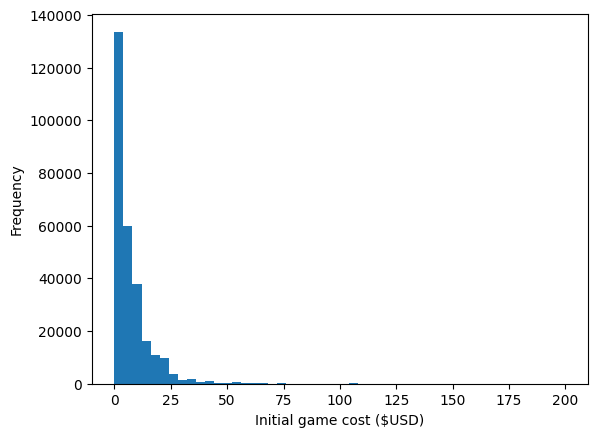

In [14]:
### Now we can begin with simple price analyses
# First create a histrogram with all prices

# Filter out outlier prices
prices = [x for x in gamesdf["initial_price"].dropna() if x < 200]
plt.hist(prices, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Initial game cost ($USD)")
plt.show()

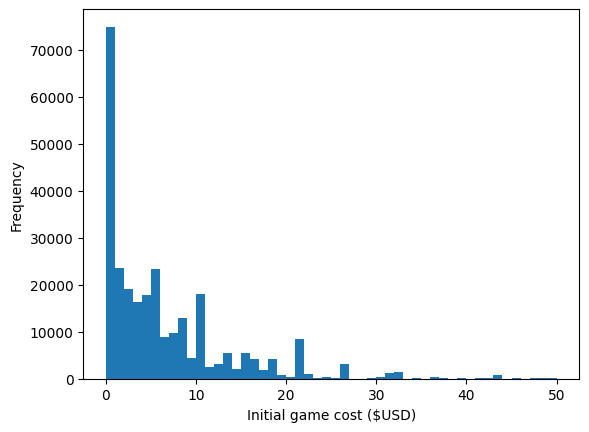

In [15]:
# Let's get a better look at the main peak of the distribution
prices = [x for x in gamesdf["initial_price"].dropna() if x < 50]
plt.hist(prices, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Initial game cost ($USD)")
plt.show()

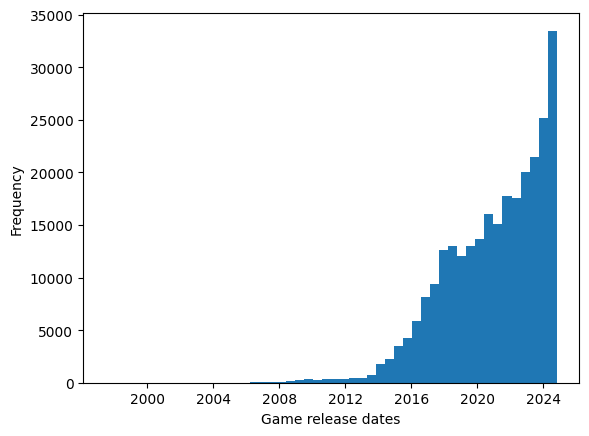

In [16]:
### Now plot games by release date
dates = gamesdf["release_date"].dropna()
plt.hist(dates, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Game release dates")
plt.show()

Text(0.5, 1.0, 'Game release date vs. Initial Price')

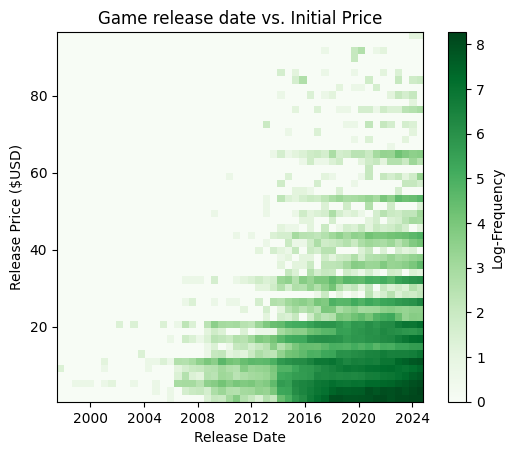

In [17]:
### Now let's see if there's a trend between game cost and release date
### Expected: game prices increase over time due to inflation
filteredgamesdf = gamesdf.dropna(subset=["release_date", "initial_price"])
filteredgamesdf = filteredgamesdf[filteredgamesdf["initial_price"] < 100]
filteredgamesdf = filteredgamesdf[filteredgamesdf["initial_price"] != 0] #Uncomment this line to remove free games from the distribution
date_min, date_max = min(filteredgamesdf["release_date"]), max(filteredgamesdf["release_date"])
price_min, price_max = min(filteredgamesdf["initial_price"]), max(filteredgamesdf["initial_price"])
heatmap, x_edges, y_edges = np.histogram2d(filteredgamesdf["release_date"], filteredgamesdf["initial_price"], bins=50)

# Apply log transformation to improve visibility
heatmap_log = np.log1p(heatmap)  # log(1 + x) to handle zeros

#plt.imshow(heatmap.T, origin='lower', cmap='hot', aspect=(x_max / y_max), extent=[x_min, x_max, y_min, y_max])
plt.imshow(heatmap_log.T, origin='lower', cmap='Greens', aspect=(date_max.year / price_max)*5, extent=[date_min, date_max, price_min, price_max])
plt.colorbar(label='Log-Frequency')
plt.xlabel('Release Date')
plt.ylabel('Release Price ($USD)')
plt.title('Game release date vs. Initial Price')

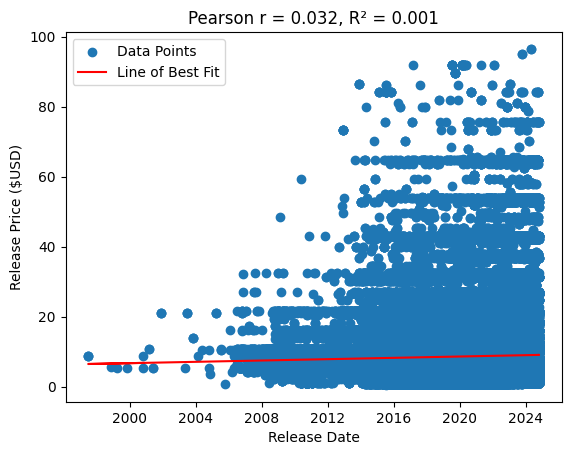

In [19]:
x = filteredgamesdf["release_date"].map(lambda d: d.toordinal())
y = filteredgamesdf["initial_price"]

# Linear regression
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x, y)
line = slope * x + intercept  # Predicted values

# Plot
plt.scatter(filteredgamesdf["release_date"], y, label="Data Points")
plt.plot(filteredgamesdf["release_date"], line, color='red', label="Line of Best Fit")

plt.xlabel("Release Date")
plt.ylabel("Release Price ($USD)")
plt.title(f"Pearson r = {r_value:.3f}, R² = {r_value**2:.3f}")
plt.legend()
plt.show()


### TODO: Add r-squared pearson test to this and line of best fit, this can be our first hypothesis test

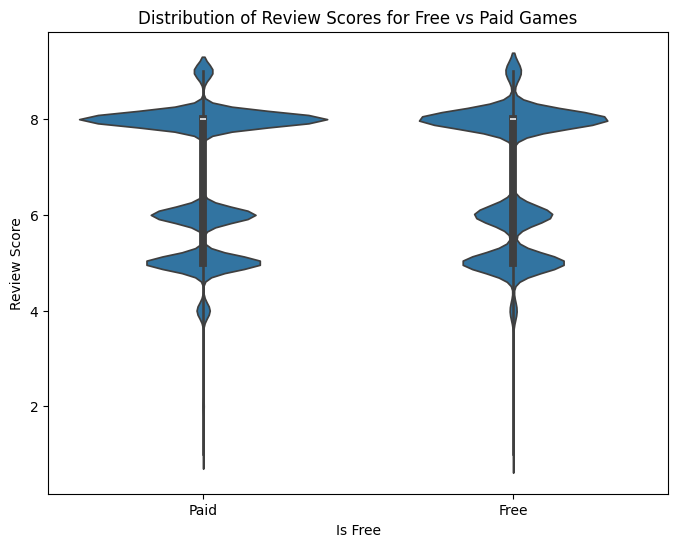

T-statistic: -1.7298827368208565, P-value: 0.08366030602059721
The difference in review scores between free and paid games is not statistically significant.


In [ ]:
# Is there a signficant difference in in review scores between free and paid games?

review_threshold = 50  # Minimum number of reviews to consider

filtered_games = gamesdf[gamesdf["total"] >= review_threshold]

# Get the dfs for review scores for free and paid games
free_games = filtered_games[filtered_games["is_free"] == True]["review_score"].dropna()
paid_games = filtered_games[filtered_games["is_free"] == False]["review_score"].dropna()

# Perform the t-test
t_stat, p_value = ttest_ind(free_games, paid_games, equal_var=False)

# Create a violin plot 
plt.figure(figsize=(8, 6))
sns.violinplot(x=filtered_games["is_free"], y=filtered_games["review_score"])
plt.xlabel("Is Free")
plt.ylabel("Review Score")
plt.title("Distribution of Review Scores for Free vs Paid Games")
plt.xticks(ticks=[0, 1], labels=["Paid", "Free"])
plt.show()

# Output t-test results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("The difference in review scores between free and paid games is statistically significant.")
else:
    print("The difference in review scores between free and paid games is not statistically significant.")